In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import binary_dilation

## F814W

### Data Import:

In [2]:
image_814 = "/Users/sujoy7471/Research_Env/3rdSem_Break/SBF/Test/M85/j9et18020/j9et18020_drc.fits"
hdul = fits.open(image_814)

In [3]:
hdul.info()
sci = hdul["SCI"].data
# sci = np.flipud(sci)   # Flip axes for correct calculations

wht = hdul["WHT"].data   # inverse variance map
hdul.close()

Filename: /Users/sujoy7471/Research_Env/3rdSem_Break/SBF/Test/M85/j9et18020/j9et18020_drc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     846   ()      
  1  SCI           1 ImageHDU        87   (4218, 4242)   float32   
  2  WHT           1 ImageHDU        44   (4218, 4242)   float32   
  3  CTX           1 ImageHDU        37   (4218, 4242)   int32   
  4  HDRTAB        1 BinTableHDU    595   8R x 293C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 3A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 23A, D, D, D, D, K, K, K, 8A, K, 23A, 9A, 20A, K, 4A, K, K, K, K, K, K, 23A, D, D, D, D, K, K, 3A, 3A, 4A, 4A, L, D, D, D, 3A, 1A, K, D, D, D, 24A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, K, D, 6A, 9A, 8A, D, D, L, 4A, 18A, 3A, K, 7A, 5A, 3A, D, 13A, 8A, 4A, 3A, L, K, L, K, L, K, K, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, 1A, 3A, 1A, D, 3A,

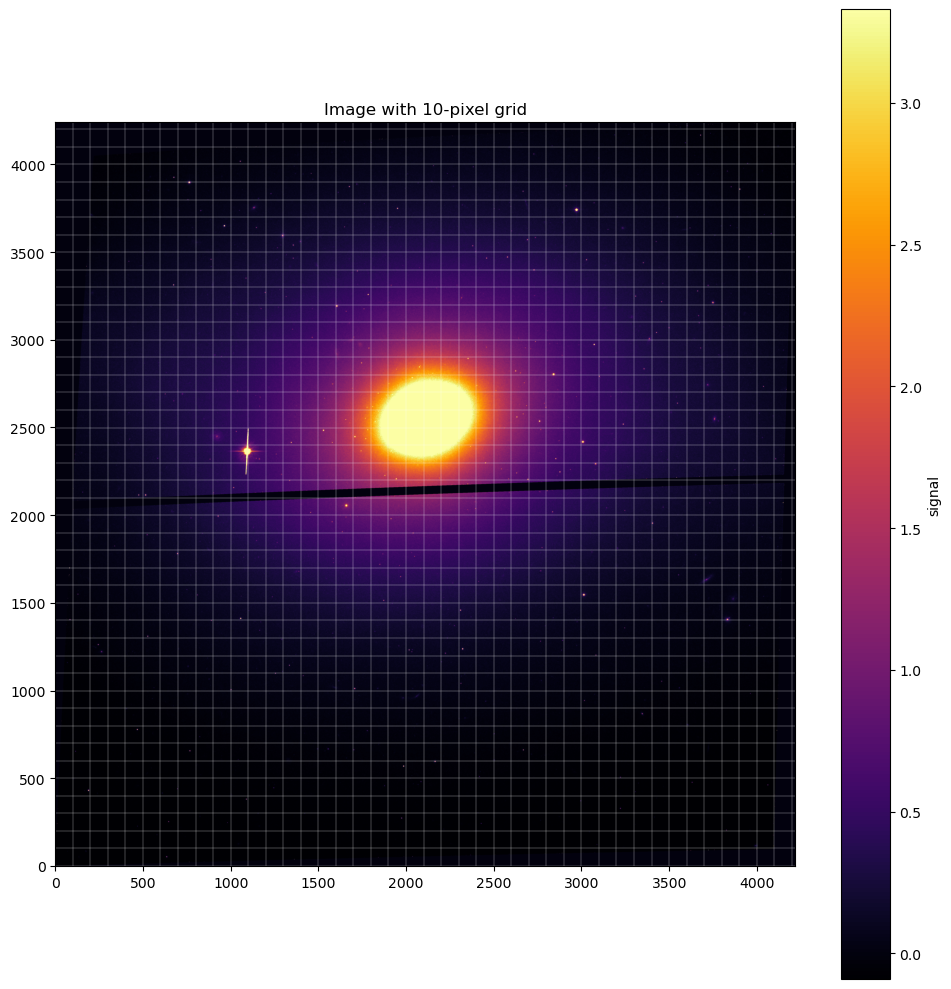

In [4]:
mask = ~np.isfinite(sci)   # True where NaN or inf
sci_masked = np.ma.array(sci, mask=mask)

sci_filled = sci_masked.filled(0.0)

vmin = np.nanpercentile(sci_filled, 5)
vmax = np.nanpercentile(sci_filled, 99)

plt.figure(figsize=(10, 10))
plt.imshow(sci_filled, origin="lower", cmap="inferno",
           vmin=vmin, vmax=vmax)
plt.colorbar(label="signal")

ny, nx = sci_filled.shape

# draw vertical grid lines every 10 pixels
for xg in range(0, nx, 100):
    plt.axvline(xg - 0.5, color="white", lw=0.2, alpha=1)

# draw horizontal grid lines every 10 pixels
for yg in range(0, ny, 100):
    plt.axhline(yg - 0.5, color="white", lw=0.2, alpha=1)

plt.title("Image with 10-pixel grid")
plt.tight_layout()
plt.show()


### Star identification and PSF:

STAR 1: Peak at (row, col) = (37, 72)


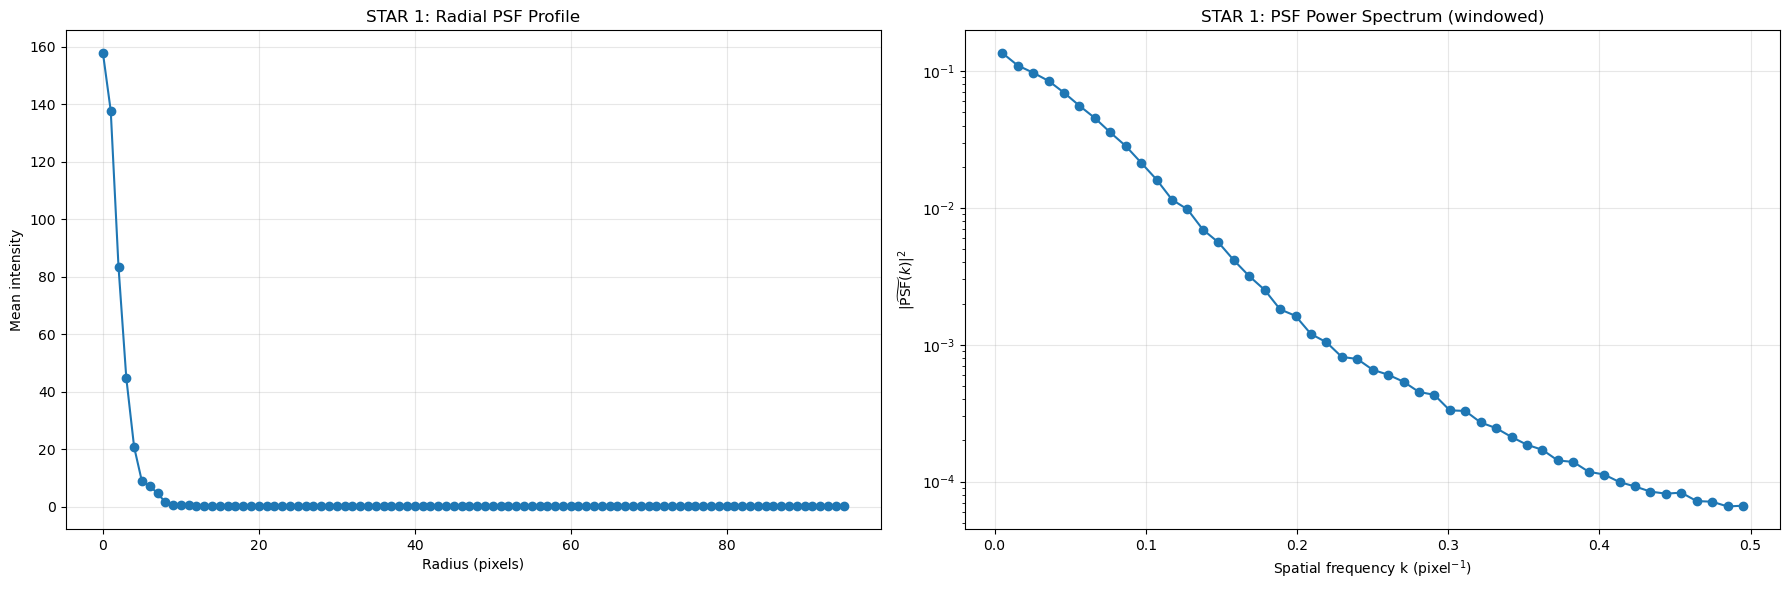

STAR 2: Peak at (row, col) = (92, 65)


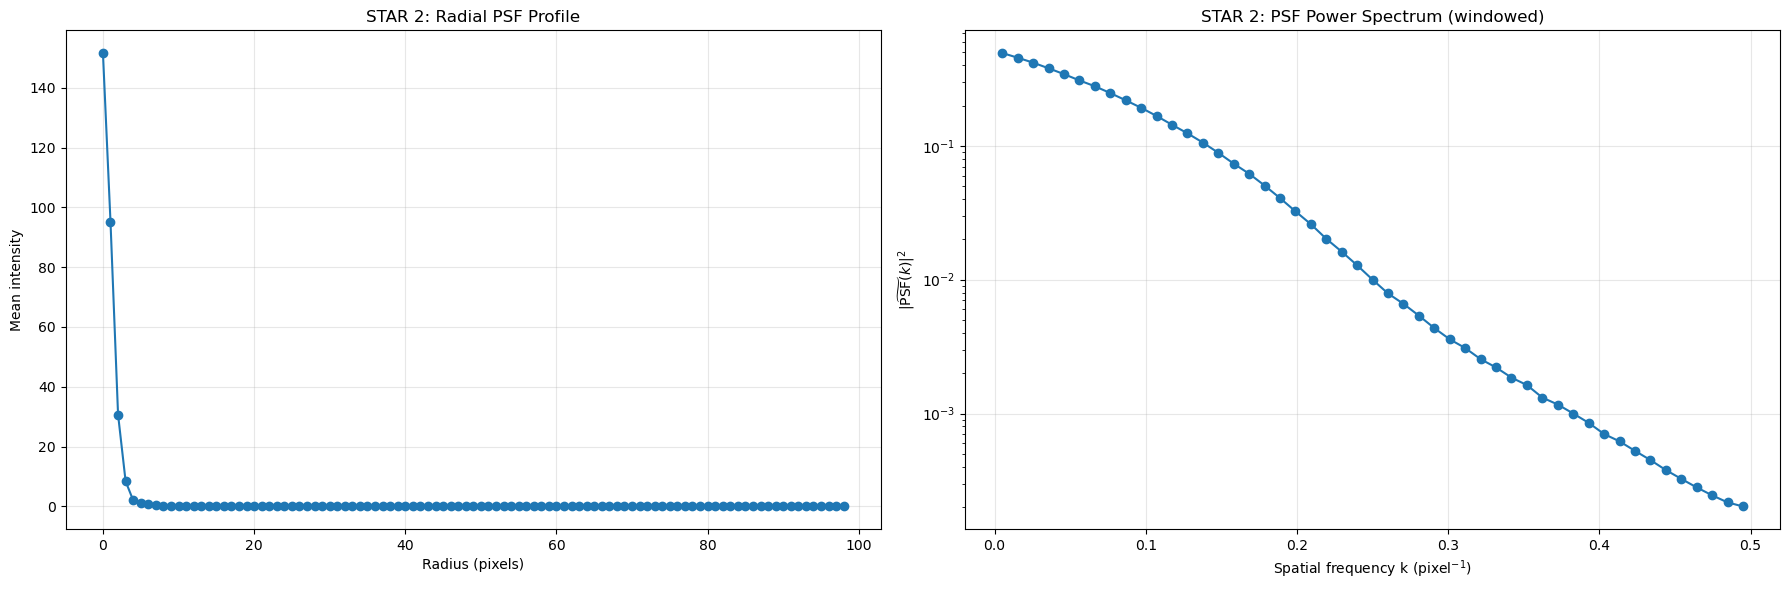

In [5]:
# =================================================
# FUNCTION TO PROCESS ONE STAR  (WINDOWED PSF)
# =================================================
def process_star(star_cutout, star_label):

    # Replace masked values for peak finding
    star_filled0 = star_cutout.filled(-np.inf)

    # -------------------------------------------------
    # 1. Find peak
    # -------------------------------------------------
    idx_flat = np.argmax(star_filled0)
    iy, ix = np.unravel_index(idx_flat, star_cutout.shape)

    print(f"{star_label}: Peak at (row, col) = ({iy}, {ix})")

    # -------------------------------------------------
    # 2. Create circular PSF mask
    # -------------------------------------------------
    ny, nx = star_cutout.shape
    y, x = np.mgrid[0:ny, 0:nx]

    radius = 100
    mask_psf = (x - ix)**2 + (y - iy)**2 > radius**2

    star_masked = np.ma.array(star_cutout, mask=mask_psf)
    star_filled = star_masked.filled(0.0)

    # -------------------------------------------------
    # 3. Normalize PSF (MANDATORY)
    # -------------------------------------------------
    psf = star_filled.copy()
    psf /= psf.sum()

    # -------------------------------------------------
    # 4. Apply SAME window function as galaxy
    # -------------------------------------------------
    win_y = np.hanning(ny)
    win_x = np.hanning(nx)
    window = win_y[:, None] * win_x[None, :]

    psf_win = psf * window

    # -------------------------------------------------
    # 5. Radial PSF profile (diagnostic only)
    # -------------------------------------------------
    r = np.sqrt((x - ix)**2 + (y - iy)**2)
    r_flat = r[~mask_psf].ravel()
    I_flat = star_masked.data[~mask_psf].ravel()

    rbins = np.arange(0, radius, 1)
    radial_I = np.zeros(len(rbins) - 1)

    for i in range(len(rbins) - 1):
        sel = (r_flat >= rbins[i]) & (r_flat < rbins[i+1])
        radial_I[i] = np.mean(I_flat[sel]) if np.any(sel) else np.nan

    # -------------------------------------------------
    # 6. FFT and PSF power spectrum (WINDOWED)
    # -------------------------------------------------
    psf_ft = np.fft.fftshift(np.fft.fft2(psf_win))
    psf_power_2d = np.abs(psf_ft)**2

    ky = np.fft.fftfreq(ny, d=1.0)
    kx = np.fft.fftfreq(nx, d=1.0)

    ky = np.fft.fftshift(ky)
    kx = np.fft.fftshift(kx)

    KX, KY = np.meshgrid(kx, ky)
    K = np.sqrt(KX**2 + KY**2)

    k_flat = K.ravel()
    P_flat = psf_power_2d.ravel()

    # -------------------------------------------------
    # 7. Nyquist-limited azimuthal averaging
    # -------------------------------------------------
    k_nyq = 0.5
    sel_nyq = k_flat <= k_nyq
    k_flat = k_flat[sel_nyq]
    P_flat = P_flat[sel_nyq]

    kbins = np.linspace(0, k_nyq, 50)
    k_cent = 0.5 * (kbins[:-1] + kbins[1:])
    P_psf_1d = np.zeros(len(k_cent))

    for i in range(len(k_cent)):
        sel = (k_flat >= kbins[i]) & (k_flat < kbins[i+1])
        P_psf_1d[i] = np.mean(P_flat[sel]) if np.any(sel) else np.nan

    # -------------------------------------------------
    # 8. Diagnostic plots (radial + power)
    # -------------------------------------------------
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.plot(rbins[:-1], radial_I, marker="o")
    plt.xlabel("Radius (pixels)")
    plt.ylabel("Mean intensity")
    plt.title(f"{star_label}: Radial PSF Profile")
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(k_cent, P_psf_1d, marker="o")
    plt.xlabel("Spatial frequency k (pixel$^{-1}$)")
    plt.ylabel(r"$|\widetilde{\mathrm{PSF}}(k)|^2$")
    plt.title(f"{star_label}: PSF Power Spectrum (windowed)")
    plt.yscale("log")
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return k_cent, P_psf_1d



# =================================================
# RUN FOR ALL THREE STARS
# =================================================

# STAR 1
star1 = sci_masked[3700:3800, 2900:3000]
k_cent814_1, P_psf_1d814_1 = process_star(star1, "STAR 1")

# STAR 2
star2 = sci_masked[3800:4000, 700:800]
k_cent814_2, P_psf_1d814_2 = process_star(star2, "STAR 2")


Saved normalized & averaged PSF power spectrum to psf_power_814.csv


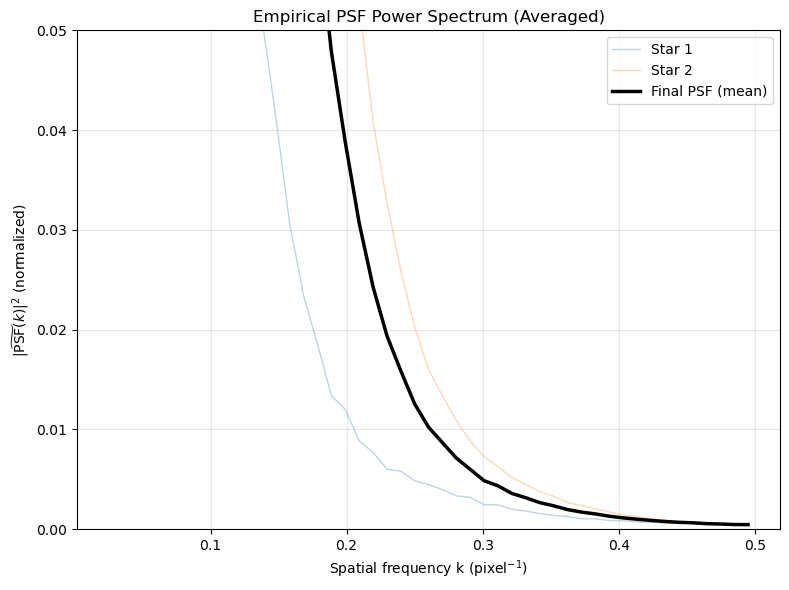

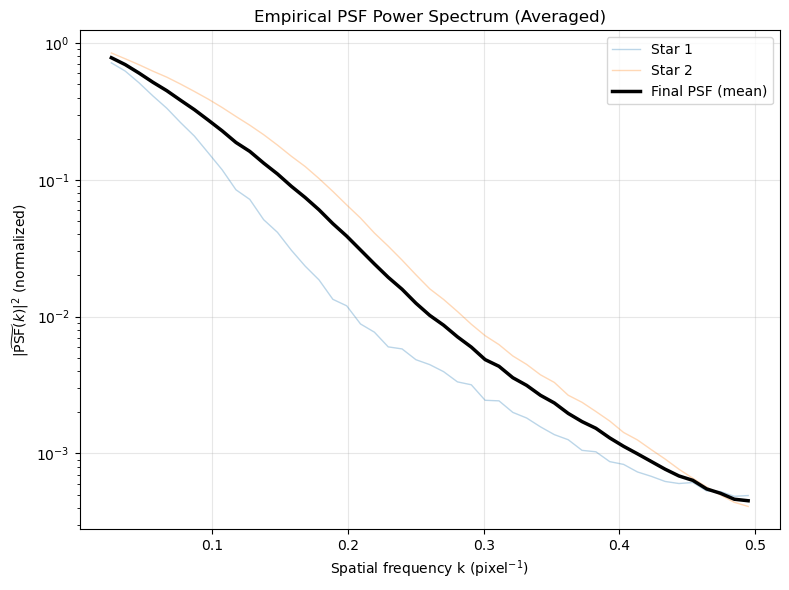

In [6]:
# -------------------------------------------------
# 1. Stack PSFs (RAW)
# -------------------------------------------------
P_stack_raw = np.vstack([
    P_psf_1d814_1,
    P_psf_1d814_2
])

# Common k-grid
k_cent814 = k_cent814_1

# -------------------------------------------------
# 2. Normalize EACH PSF individually
# -------------------------------------------------
P_stack = np.zeros_like(P_stack_raw)

for i in range(P_stack_raw.shape[0]):
    norm_i = np.nanmax(P_stack_raw[i])
    P_stack[i] = P_stack_raw[i] / norm_i

# -------------------------------------------------
# 3. Compute mean and scatter of normalized PSFs
# -------------------------------------------------
P_psf_mean = np.nanmean(P_stack, axis=0)
P_psf_std  = np.nanstd(P_stack, axis=0)

# -------------------------------------------------
# 4. Remove first two low-k bins
# -------------------------------------------------
k_cent814_clean = k_cent814[2:]
P_psf_mean_clean = P_psf_mean[2:]
P_psf_std_clean  = P_psf_std[2:]
P_stack_clean    = P_stack[:, 2:]

# -------------------------------------------------
# 5. Save to CSV (EXACT column names)
# -------------------------------------------------
data = np.column_stack((k_cent814_clean, P_psf_mean_clean))

np.savetxt(
    "psf_power_814.csv",
    data,
    delimiter=",",
    header="k_pixel_inv,PSF_power",
    comments=""
)

print("Saved normalized & averaged PSF power spectrum to psf_power_814.csv")

# -------------------------------------------------
# 6. Plot (linear scale)
# -------------------------------------------------
plt.figure(figsize=(8, 6))

for i, P in enumerate(P_stack_clean, start=1):
    plt.plot(k_cent814_clean, P, alpha=0.3, lw=1,
             label=f"Star {i}")

plt.plot(k_cent814_clean, P_psf_mean_clean, "k", lw=2.5,
         label="Final PSF (mean)")

plt.ylim(0, 0.05)
plt.xlabel("Spatial frequency k (pixel$^{-1}$)")
plt.ylabel(r"$|\widetilde{\mathrm{PSF}}(k)|^2$ (normalized)")
plt.title("Empirical PSF Power Spectrum (Averaged)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 7. Plot (log scale)
# -------------------------------------------------
plt.figure(figsize=(8, 6))

for i, P in enumerate(P_stack_clean, start=1):
    plt.plot(k_cent814_clean, P, alpha=0.3, lw=1,
             label=f"Star {i}")

plt.plot(k_cent814_clean, P_psf_mean_clean, "k", lw=2.5,
         label="Final PSF (mean)")

plt.yscale("log")
plt.xlabel("Spatial frequency k (pixel$^{-1}$)")
plt.ylabel(r"$|\widetilde{\mathrm{PSF}}(k)|^2$ (normalized)")
plt.title("Empirical PSF Power Spectrum (Averaged)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
